In [1]:
import pandas as pd
import numpy as np
import keras
from keras.utils.data_utils import get_file
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from os.path import join
import multiprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import skew, kurtosis, tvar, entropy, pearsonr
import keras.backend.tensorflow_backend as K

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_HOME = '../lfw-aligned-with-42-margin-resized/'

In [3]:
PAIRS_PATH = '../pairs.txt'

In [4]:
raw_dataset = pd.read_csv(PAIRS_PATH, nrows=None)
raw_dataset.columns = ['data']

In [5]:
raw_dataset.shape

(6000, 1)

In [6]:
raw_dataset = raw_dataset

In [7]:
def split_raw_data(row):
    fields = str(row[0]).split('\t')
    is_the_same = 0
    path1, path2 = '{}/{}_{:04d}.png', '{}/{}_{:04d}.png'
    if len(fields) == 3:
        is_the_same = 1
        path1 = path1.format(fields[0], fields[0], int(fields[1]))
        path2 = path2.format(fields[0], fields[0], int(fields[2]))
    elif len(fields) == 4:
        path1 = path1.format(fields[0], fields[0], int(fields[1]))
        path2 = path2.format(fields[2], fields[2], int(fields[3]))
    else:
        raise(Exception('invalid fields'))
    
    return pd.Series([path1, path2, is_the_same], ['path1', 'path2', 'is_the_same']) 

In [8]:
dataset = raw_dataset.apply(split_raw_data, axis=1)

In [9]:
dataset.head()

,path1,path2,is_the_same
0,Abel_Pacheco/Abel_Pacheco_0001.png,Abel_Pacheco/Abel_Pacheco_0004.png,1
1,Akhmed_Zakayev/Akhmed_Zakayev_0001.png,Akhmed_Zakayev/Akhmed_Zakayev_0003.png,1
2,Akhmed_Zakayev/Akhmed_Zakayev_0002.png,Akhmed_Zakayev/Akhmed_Zakayev_0003.png,1
3,Amber_Tamblyn/Amber_Tamblyn_0001.png,Amber_Tamblyn/Amber_Tamblyn_0002.png,1
4,Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_00...,Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_00...,1


In [10]:
dataset.shape

(6000, 3)

In [11]:
from PIL import Image

def path2ImgVec(path):
    x = img_to_array(load_img(join(DATA_HOME, path)))
#     x = img_to_array(load_img(join(DATA_HOME, path)).convert('L'))
    return x.reshape((1,) + x.shape)

def path2ImgVecFlipped(path):
    img = load_img(join(DATA_HOME, path))
#     img = load_img(join(DATA_HOME, path)).convert('L')
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    x = img_to_array(img)
    return x.reshape((1,) + x.shape)

In [12]:
img_paths = list(set(dataset.path1.tolist()+dataset.path2.tolist()))
len(img_paths)

7701

In [13]:
pool = multiprocessing.Pool(8)
results1 = pool.map(path2ImgVec, img_paths)
pool.close()
pool.join()

In [14]:
pool = multiprocessing.Pool(8)
results2 = pool.map(path2ImgVecFlipped, img_paths)
pool.close()
pool.join()

In [15]:
img_vecs1 = np.vstack(results1)
img_vecs1.shape
img_vecs2 = np.vstack(results2)
img_vecs2.shape

(7701, 55, 47, 3)

In [16]:
input_shape = img_vecs1.shape[1:]
img_vecs1.shape

(7701, 55, 47, 3)

In [17]:
from keras.models import load_model

# model = load_model('../models/facescrub-faceonly-simple-cnn.model.h5')
# 0.250667	0.014855	0.240852	0.003922

# model = load_model('../models/webface-simple-cnn.3348.model.h5')
# 0.258	0.012423	0.247926	0.001509

# model = load_model('../models/webface-simple-cnn.aligned.margin16.model.h5')
# 0.188000	0.009123	0.174352	0.001018

# model = load_model('../models/webface-simple-cnn.aligned.margin32-1.model.h5')
# 0.158667	0.009684	0.149889	0.001223

# model = load_model('../models/webface-facescrub-faceonly-simple-cnn.aligned.model.h5')
# 0.146333	0.015720	0.137333	0.002688

# model = load_model('../models/webface-facescrub-faceonly-simple-cnn.aligned.selected.model.h5')
# 0.149667	0.012601	0.119389	0.002129

# model = load_model('../models/webface-facescrub-faceonly-simple-cnn.aligned.augment.model.h5')

# model = load_model('../models/webface-facescrub-faceonly-simple-cnn.aligned.flipped.model.h5')
# with <6 augmentation
# 0.131	0.010220	0.099037	0.002640

# model = load_model('../models/webface-full-simple-cnn.aligned.margin32.model.h5')
# about 60% data ?
# 0.111667	0.011571	0.099852	0.002124
# All data
# 0.102500	0.011908	0.065889	0.001608

# model = load_model('../models/webface-full-simple-cnn.aligned.margin32.s20.model.h5')
# 0.100333	0.013392	0.082704	0.001788
# with lfw flipped
#*0.095833	0.013627	0.077963	0.000824
# with distance
# 0.094500	0.013272	0.070222	0.002491

# model = load_model('../models/webface-full-simple-cnn.aligned.margin32.grey.model.h5')
# All data
# 0.114000	0.012936	0.094685	0.001828
# All data + flipped
# 0.106500	0.011772	0.081500	0.002122
# 0.105167	0.010735	0.089592	0.001551

# model = load_model('../models/webface-full-simple-cnn.A.aligned.margin32.s20.model.h5')
# with lfw flipped
# 0.105333	0.011101	0.069389	0.001656
# with joint bayes
# 0.102167	0.011427	0.083241	0.001384

# model = load_model('../models/webface-full-simple-cnn.aligned.margin16.s20.model.h5')
# with lfw flipped
# 0.106167	0.013438	0.081222	0.001876
# with distance
# 0.100333	0.014411	0.080370	0.001809

# model = load_model('../models/webface-full-simple-cnn.aligned.margin4.s20.model.h5')
# with lfw flipped
# 0.107667	0.015762	0.062593	0.001863
# with distance
# 0.100167	0.014841	0.091148	0.001693

# model = load_model('../models/webface-full-simple-cnn.aligned.margin42.s20.model.h5')
# with lfw flipped
# 0.100667	0.013106	0.077389	0.002303
# with distance
# 0.095167	0.014822	0.082926	0.002182

# model = load_model('../models/celeba-full-simple-cnn.aligned.margin32.model.h5')
# 0.139167 	0.018488 	0.131982 	0.002264

# model = load_model('../models/celeba-full-simple-cnn.aligned.margin32.flipped.model.h5')
# 0.126500 	0.009957 	0.114055 	0.002217

# model = load_model('../models/celeba-full-simple-cnn.aligned.margin32.flipped.s20.model.h5')
# 0.111500	0.011315	0.097333	0.001769
# 0.112833	0.014645	0.097611	0.002232
# with distance
# 0.110000	0.009129	0.085722	0.001767

# model = load_model('../models/celeba-full-simple-cnn.aligned.margin16.flipped.s20.model.h5')
# with lfw flipped
# 0.117833	0.016160	0.099574	0.002313
# with distance
# 0.116833	0.013874	0.086370	0.002919

# model = load_model('../models/celeba-full-simple-cnn.aligned.margin4.flipped.s20.model.h5')
# with lfw flipped
# 0.122333	0.012871	0.094204	0.002562
# with distance
# 0.118833	0.006669	0.093166	0.002160

model = load_model('../models/celeba-full-simple-cnn.aligned.margin42.flipped.s20.model.h5')
# with lfw flipped
# 0.117167	0.014815	0.106056	0.001996
# with distance
# 0.117833	0.015830	0.104704	0.001600

# model = load_model('../models/webface-full-celeba-simple-cnn.aligned.margin32.grey.model.h5')
# 0.107333	0.013085	0.089500	0.001393

# model = load_model('../models/webface-full-celeba-simple-cnn.aligned.margin32.grey.flipped.s20.model.h5')
# 0.101000	0.013646	0.088574	0.002227
# 0.098667	0.014020	0.082630	0.001580
# 0.098333	0.013333	0.082704	0.001736
# 0.100500	0.009547	0.090111	0.001466
# 0.093667	0.010214	0.065185	0.001320

# with lfw flipped
#*090667	0.007079	0.056815	0.001879\
# more distance
# 0.086667	0.007303	0.057519	0.002095

# model = load_model('../models/webface-full-celeba-simple-cnn.aligned.margin16.grey.flipped.s20.model.h5')
# with lfw flipped
# 0.099000	0.013000	0.061352	0.001969
# with distance
# 0.092000	0.013183	0.063241	0.001133

# model = load_model('../models/webface-full-celeba-simple-cnn.aligned.margin4.grey.flipped.s20.model.h5')
# with lfw flipped
# 0.108167	0.012963	0.068370	0.002075
# with distance
# 	0.099667	0.010214	0.073944	0.001606

# model = load_model('../models/webface-full-celeba-simple-cnn.aligned.margin42.grey.flipped.s20.model.h5')
# with lfw flipped
# 0.100500	0.012781	0.078445	0.001869
# with distance
# 0.092667	0.011884	0.076907	0.002318


In [18]:
from keras import backend as K
inp = model.input

outputs = [model.layers[-2].output]
functor = K.function([inp] + [K.learning_phase()], outputs)

In [19]:
img_vecs1.shape

(7701, 55, 47, 3)

In [20]:
deepids1 = functor([img_vecs1, 1.])[0]

In [21]:
deepids2 = functor([img_vecs2, 1.])[0]

In [22]:
deepids1.shape

(7701, 160)

In [23]:
img_paths_flipped = ["~"+i for i in img_paths]

In [24]:
deepids = np.vstack([deepids1, deepids2])

In [25]:
deepids.shape

(15402, 160)

In [26]:
img_deepid_mem = {k:v for k, v in zip(img_paths+img_paths_flipped, deepids)}

In [27]:
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis


def to_deepid_features(row):
    vec1 = img_deepid_mem[row['path1']]
    vec2 = img_deepid_mem[row['path2']]

    fvec1 = img_deepid_mem["~"+row['path1']]
    fvec2 = img_deepid_mem["~"+row['path2']]
    
    feats = [
        cosine(vec1, vec2),
        cosine(vec1, fvec2),
        cosine(fvec1, vec2),
        cosine(fvec1, fvec2),
        cityblock(vec1, vec2),
        canberra(vec1, vec2),
        euclidean(vec1, vec2),
        minkowski(vec1, vec2, 3),
        braycurtis(vec1, vec2),
        skew(vec1),
        skew(vec2),
        kurtosis(vec1),
        kurtosis(vec2),
        tvar(vec1),
        tvar(vec2),
    ]
    
    return pd.Series(feats + [row['is_the_same']], ['z_'+str(i) for i in range(len(feats))] + ['is_the_same']) 

In [28]:
feat_dataset = dataset.apply(to_deepid_features, axis=1)

In [29]:
feat_dataset.head()

,z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_10,z_11,z_12,z_13,z_14,is_the_same
0,0.444337,0.455961,0.431830,0.388360,385.470520,89.663260,41.320644,21.234644,0.528410,1.118911,1.428116,0.551219,1.682273,6.561150,7.130279,1.0
1,0.227899,0.240157,0.279348,0.273742,272.473969,61.437836,30.953049,16.112365,0.356385,1.162866,1.056411,0.785768,0.593453,7.944428,6.586450,1.0
2,0.331572,0.361793,0.304314,0.350810,332.856873,76.026418,37.035301,19.615418,0.429315,1.046581,1.056411,0.532230,0.593453,7.376277,6.586450,1.0
3,0.255179,0.273545,0.294155,0.288005,329.180603,63.036556,38.120068,20.437334,0.375706,0.965596,1.393724,0.307968,1.408756,9.148125,11.488263,1.0
4,0.370672,0.361395,0.381454,0.384775,368.235260,86.747124,40.027325,20.815452,0.480957,0.803261,1.248979,-0.375434,0.881707,5.509652,9.440453,1.0


In [30]:
feat_dataset.tail()

,z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_10,z_11,z_12,z_13,z_14,is_the_same
5995,0.497665,0.490360,0.478229,0.475118,449.287964,93.399739,47.987968,24.578508,0.550104,1.112994,0.981901,0.665223,-0.180813,8.335918,7.582238,0.0
5996,0.540469,0.554548,0.512650,0.505362,448.568542,99.479569,47.559700,24.297449,0.568288,1.070298,1.048877,0.430165,0.365568,6.147604,7.729656,0.0
5997,0.554738,0.576017,0.557717,0.551608,525.749878,105.363857,55.152763,28.369318,0.597660,1.228675,0.874150,0.660329,-0.097289,11.725911,7.169877,0.0
5998,0.537418,0.508089,0.525587,0.506557,483.291870,103.457728,50.293339,25.471744,0.598128,1.090085,1.143220,0.696390,0.383798,8.558986,8.112764,0.0
5999,0.630925,0.594673,0.616807,0.603682,510.989868,110.538207,53.613232,27.361130,0.656854,1.131980,1.248967,0.603042,0.717309,7.098961,9.568910,0.0


In [31]:
col = [c for c in feat_dataset.columns if c[0]=='z']

X = feat_dataset[col].as_matrix()
y = feat_dataset['is_the_same'].as_matrix()

In [32]:
X[0]

array([   0.44433663,    0.45596127,    0.43183002,    0.38835995,
        385.47052002,   89.66325972,   41.32064438,   21.23464414,
          0.52841029,    1.11891055,    1.42811561,    0.55121909,
          1.68227257,    6.56114995,    7.13027856])

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [34]:
import xgboost as xgb
params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = ['logloss', 'error']
# params["eta"] = 0.02
# params["subsample"] = 0.7
# params["min_child_weight"] = 1
# params["colsample_bytree"] = 0.7
params["max_depth"] = 4
params["seed"] = 1632

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=100)

[0]	train-logloss:0.523885	train-error:0.113519	valid-logloss:0.524997	valid-error:0.113333
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 50 rounds.
[100]	train-logloss:0.117756	train-error:0.035	valid-logloss:0.273082	valid-error:0.106667
Stopping. Best iteration:
[130]	train-logloss:0.092484	train-error:0.02	valid-logloss:0.28006	valid-error:0.098333



In [35]:
d_all = xgb.DMatrix(X, label=y)

xgb.cv(params, d_all, 500, nfold=10, metrics=['error'], shuffle=False, early_stopping_rounds=50, seed=42)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.119833,0.013853,0.110611,0.001691
1,0.118166,0.011266,0.107315,0.002130
2,0.118000,0.015524,0.106704,0.001879
3,0.118500,0.013773,0.105463,0.001587
4,0.117833,0.015830,0.104704,0.001600


In [36]:
np.save('../output/celeba-full-simple-cnn.aligned.margin42.flipped.s20.model.h5.x.npy', X)

In [37]:
np.sum(y)

3000.0

In [38]:
y.shape

(6000,)

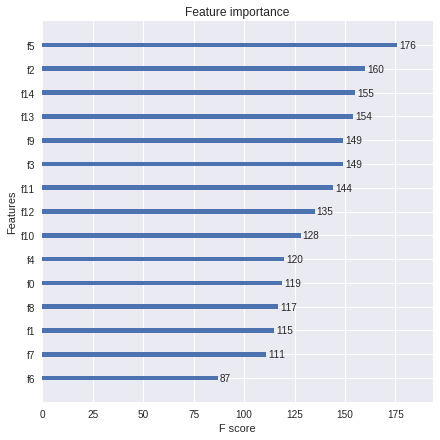

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(bst); plt.show()